In [1]:
import os
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
import xarray as xr
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import (
    BayesianRidge,
    ElasticNet,
    LinearRegression,
    SGDRegressor,
)
from sklearn.model_selection import (
    KFold,
    ShuffleSplit,
    cross_val_score,
    train_test_split,
)
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from tqdm import tqdm
from utils import DATA_ROOT

SPECTRAL_PATH = "/Users/nikola/work-brain/eeg_microstate_and_latent_space/results/20211111_EEG_ECvsEO_spectral_diffs"

# plt.style.use("default_light")

## Input data - X

In [2]:
df = xr.open_dataarray(
    os.path.join(SPECTRAL_PATH, "epochs_bands_envelopes.nc"), engine="netcdf4"
)
df.name = "band_envelopes"

In [3]:
reg_data = (
    df.mean(["time", "channels"])
    .to_dataframe()
    .unstack(level=[0])
    .reset_index()
    .set_index("subject_id")
)
reg_data.columns = reg_data.columns.droplevel(0)
reg_data = reg_data.dropna()
reg_data.columns = ["data_type", "Delta", "Theta", "Alpha", "Beta", "Gamma"]
reg_data = reg_data.pivot(columns="data_type")
reg_data.columns = ["-".join(col).strip() for col in reg_data.columns.values]

In [4]:
reg_data

,Delta-EC,Delta-EO,Theta-EC,Theta-EO,Alpha-EC,Alpha-EO,Beta-EC,Beta-EO,Gamma-EC,Gamma-EO
subject_id,,,,,,,,,,
sub-010002,2.993930,3.164167,2.940628,2.861702,3.882439,2.698230,5.334057,4.790093,1.963720,2.185678
sub-010003,6.098656,4.107057,9.259059,4.901393,9.898258,5.052342,5.665114,4.005586,1.294535,1.265628
sub-010004,3.640787,2.907276,4.946041,3.596163,4.840295,3.442435,3.856988,3.500317,1.233090,1.270905
sub-010005,6.030394,6.758357,7.609019,6.043660,8.134223,5.541237,5.356008,5.248698,1.104512,1.797159
sub-010006,3.043016,2.636200,5.457433,2.946980,5.553533,3.076712,4.346854,3.646848,1.593718,1.787737
...,...,...,...,...,...,...,...,...,...,...
sub-010316,3.758198,3.776634,3.769392,3.610739,4.336869,2.120185,2.879526,2.054328,1.102948,1.048336
sub-010317,3.241832,3.306675,3.177971,2.853346,4.049105,2.468784,2.477574,2.250729,0.869303,0.892929
sub-010318,5.134657,4.050201,4.420577,3.287887,5.115415,2.467793,5.689086,4.175461,1.794644,1.759068


## Output - Y

In [5]:
cognitive = {}

df = pd.read_csv(os.path.join(DATA_ROOT, "cognitive_LEMON", "CVLT.csv"))
df = df.rename(columns={"ID": "subject_id"}).drop("CVLT_16", axis=1)
cognitive["CVLT"] = deepcopy(df)

df = pd.read_csv(os.path.join(DATA_ROOT, "cognitive_LEMON", "LPS.csv"))
df = df.rename(columns={"ID": "subject_id"}).drop("LPS_2", axis=1)
cognitive["LPS"] = deepcopy(df)

df = pd.read_csv(os.path.join(DATA_ROOT, "cognitive_LEMON", "RWT.csv"))
df = df.rename(columns={"ID": "subject_id"}).drop(["RWT_12", "RWT_24"], axis=1)
cognitive["RWT"] = deepcopy(df)

df = pd.read_csv(os.path.join(DATA_ROOT, "cognitive_LEMON", "TAP-Alertness.csv"))
df = df.rename(columns={"ID": "subject_id"}).drop("TAP_A_17", axis=1)
cognitive["TAP_A"] = deepcopy(df)

df = pd.read_csv(os.path.join(DATA_ROOT, "cognitive_LEMON", "TAP-Incompatibility.csv"))
df = df.rename(columns={"ID": "subject_id"}).drop("TAP_I_28", axis=1)
cognitive["TAP_I"] = deepcopy(df)

df = pd.read_csv(os.path.join(DATA_ROOT, "cognitive_LEMON", "TAP-Working Memory.csv"))
df = df.rename(columns={"ID": "subject_id"}).drop("TAP_WM_12", axis=1)
cognitive["TAP_WM"] = deepcopy(df)

df = pd.read_csv(os.path.join(DATA_ROOT, "cognitive_LEMON", "TMT.csv"))
df = df.rename(columns={"ID": "subject_id"}).drop(["TMT_4", "TMT_8"], axis=1)
cognitive["TMT"] = deepcopy(df)

df = pd.read_csv(os.path.join(DATA_ROOT, "cognitive_LEMON", "WST.csv"))
df = df.rename(columns={"ID": "subject_id"}).drop("WST_5", axis=1)
cognitive["WST"] = deepcopy(df)

In [24]:
for cog_df in cognitive.values():
    for col in cog_df.drop("subject_id", axis=1).columns:
        cog_df[col] = pd.to_numeric(cog_df[col], errors="coerce")

In [7]:
classifiers = {
    "SVR": MultiOutputRegressor(SVR()),
    "BayesRidge": MultiOutputRegressor(BayesianRidge()),
    "GradientBoostingR": MultiOutputRegressor(GradientBoostingRegressor()),
    "SGDR": MultiOutputRegressor(SGDRegressor()),
    "LightGBM": MultiOutputRegressor(LGBMRegressor()),
    "linear": LinearRegression(),
    "ElasticNet": ElasticNet(),
    "RandomForest": RandomForestRegressor(),
    # "KernelRidge": KernelRidge(),
}

In [25]:
results = pd.DataFrame()
pbar = tqdm(total=len(cognitive) * len(classifiers) * 2)
for beh_name, cog_df in cognitive.items():
    x_data = deepcopy(reg_data)
    cog_df = cog_df.set_index("subject_id")
    # match indices
    in_both = np.intersect1d(x_data.dropna().index, cog_df.dropna().index)
    if len(in_both) < 10:
        pbar.update(2*len(classifiers))
        continue
    x_data = x_data.loc[in_both, :]
    cog_df = cog_df.loc[in_both, :]
    x = x_data.values
    y = cog_df.astype(float).values
    scaler = StandardScaler()
    x = scaler.fit_transform(x)
    y = scaler.fit_transform(y)
    for name, clf in classifiers.items():
        folds = KFold(n_splits=20, shuffle=True)
        scores = cross_val_score(clf, x, y, scoring="r2", cv=folds, n_jobs=8)
        temp = pd.DataFrame({"R2": scores})
        temp["regressor"] = name
        temp["dataset"] = beh_name
        temp["CV method"] = "KFold: 20"
        results = pd.concat([results, temp])
        pbar.update(1)

        ss = ShuffleSplit(n_splits=10, train_size=0.7)
        scores = cross_val_score(clf, x, y, scoring="r2", cv=ss, n_jobs=8)
        temp = pd.DataFrame({"R2": scores})
        temp["regressor"] = name
        temp["dataset"] = beh_name
        temp["CV method"] = "ShuffleSplit: 10 / 0.7"
        results = pd.concat([results, temp])
        pbar.update(1)



  0%|                                                                                                                                                                               | 0/128 [00:00<?, ?it/s]

  1%|█▎                                                                                                                                                                     | 1/128 [00:01<03:15,  1.54s/it]

  2%|███▉                                                                                                                                                                   | 3/128 [00:01<00:57,  2.16it/s]

  4%|██████▌                                                                                                                                                                | 5/128 [00:04<02:03,  1.00s/it]

  5%|███████▊                                                                                                                                                               | 

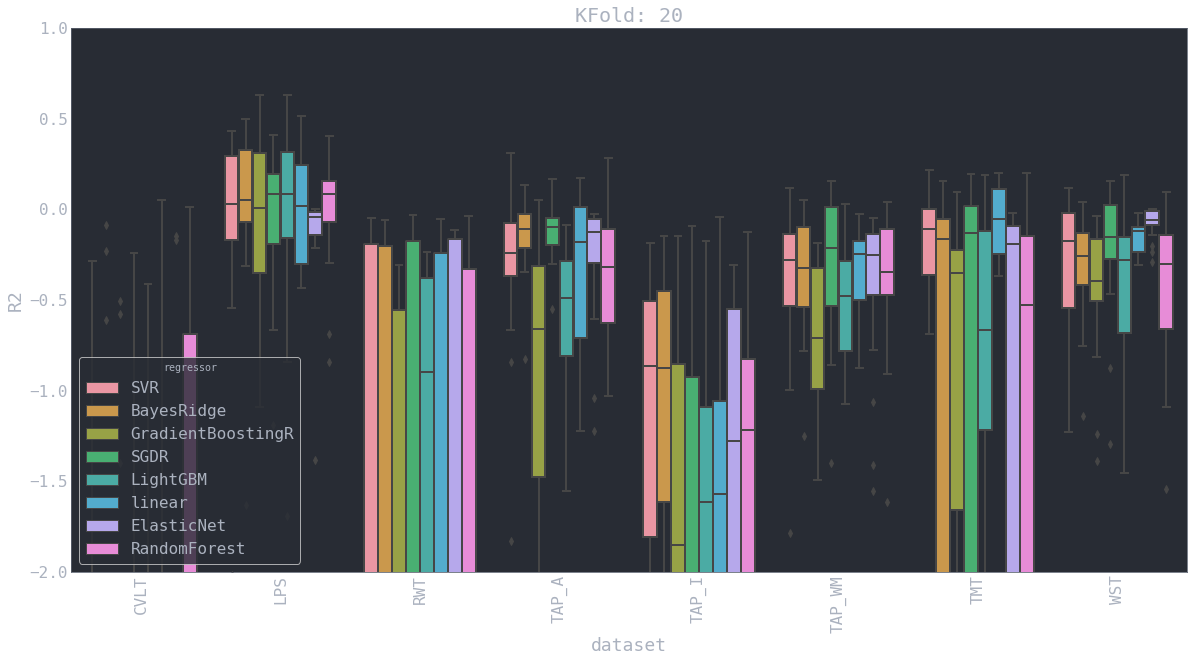

  0%|                                                                                                                                                                               | 0/128 [26:00<?, ?it/s]


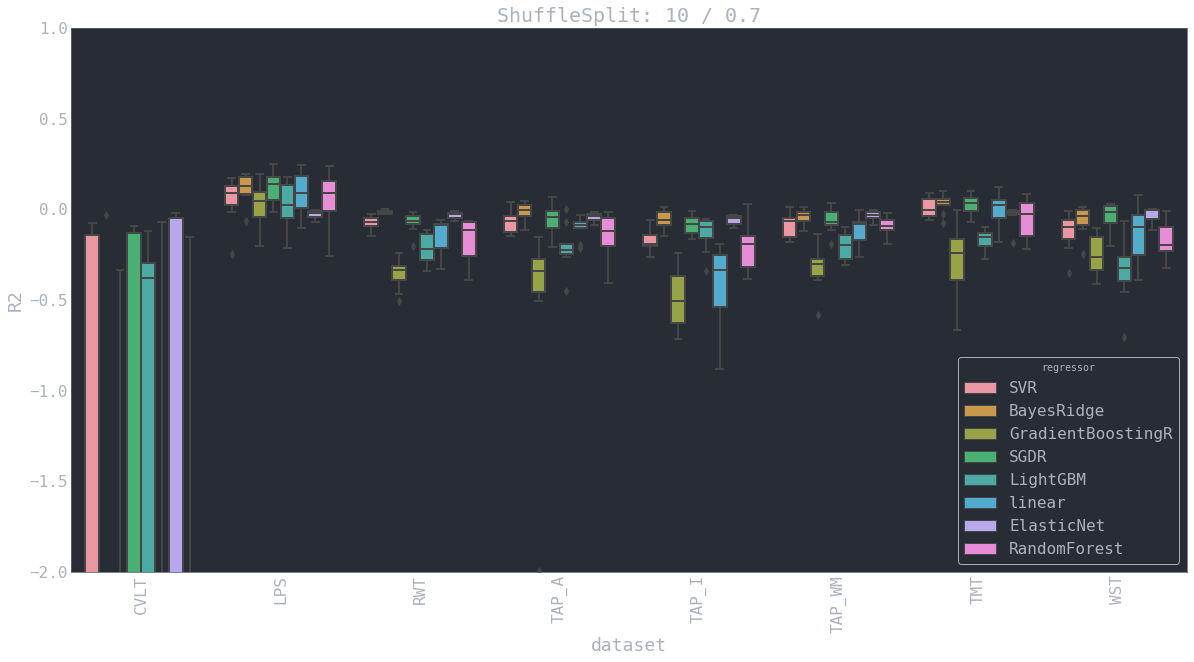

/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-pack

In [26]:
for name, df_ in results.groupby("CV method"):
    plt.figure(figsize=(20, 10))
    sns.boxplot(data=df_, x="dataset", y="R2", hue="regressor")
    plt.ylim([-2, 1])
    plt.xticks(rotation=90)
    plt.title(name)
    plt.show()

# g = sns.FacetGrid(results, col="CV method", row="dataset", ylim=[-2, 1], size=5)
# g.map(sns.boxplot, "dataset", "R2", "regressor")
